# Imports


In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#Downloading the Flowers Dataset using TensorFlow Datasets

In [4]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


# Printing Information about the Flowers Dataset


In [5]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



The images in the Flowers dataset are not all the same size.

In [6]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


# Reformat Images and Create Batches

A function that reformats all images to the resolution expected by MobileNet v2 (224, 224) and normalizes them. The function takes in an `image` and a `label` as arguments and returns the new `image` and corresponding `label`. Then create training and validation batches of size `32`.

In [7]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

# Do Simple Transfer Learning with TensorFlow Hub

Let's now use TensorFlow Hub to do Transfer Learning.

### Create a Feature Extractor
In the cell below create a `feature_extractor` using MobileNet v2. The partial model from TensorFlow Hub (without the final classification layer) is called a feature vector. Go to the [TensorFlow Hub documentation](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) to see a list of available feature vectors. Click on the `tf2-preview/mobilenet_v2/feature_vector`. Read the documentation and get the corresponding `URL` to get the MobileNet v2 feature vector. Finally, create a `feature_extractor` by using `hub.KerasLayer` with the correct `input_shape` parameter.

In [8]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

### Freeze the Pre-Trained Model



In [9]:
feature_extractor.trainable = False

### Attach a classification head

In the cell below create a `tf.keras.Sequential` model, and add the pre-trained model and the new classification layer. Remember that the classification layer must have the same number of classes as our Flowers dataset. Finally print a summary of the Sequential model.

In [10]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


### Training the model

In the cell bellow train this model like any other, by first calling `compile` and then followed by `fit`. Make sure you use the proper parameters when applying both methods. Train the model for only 6 epochs.

In [11]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 15

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/15
81/81 [==============================] - 12s 73ms/step - loss: 0.8296 - accuracy: 0.6831 - val_loss: 0.4996 - val_accuracy: 0.8183
Epoch 2/15
81/81 [==============================] - 4s 49ms/step - loss: 0.3991 - accuracy: 0.8626 - val_loss: 0.3804 - val_accuracy: 0.8701
Epoch 3/15
81/81 [==============================] - 4s 53ms/step - loss: 0.3145 - accuracy: 0.8972 - val_loss: 0.3433 - val_accuracy: 0.8783
Epoch 4/15
81/81 [==============================] - 4s 49ms/step - loss: 0.2591 - accuracy: 0.9183 - val_loss: 0.3158 - val_accuracy: 0.8874
Epoch 5/15
81/81 [==============================] - 4s 48ms/step - loss: 0.2270 - accuracy: 0.9323 - val_loss: 0.3064 - val_accuracy: 0.8992
Epoch 6/15
81/81 [==============================] - 4s 52ms/step - loss: 0.1959 - accuracy: 0.9455 - val_loss: 0.2961 - val_accuracy: 0.8955
Epoch 7/15
81/81 [==============================] - 4s 53ms/step - loss: 0.1735 - accuracy: 0.9556 - val_loss: 0.3006 - val_accuracy: 0.8983
Epoch 8/15
8

You can see we get ~91% validation accuracy with only 6 epochs of training, which is absolutely awesome. This is a huge improvement over the model we created in the previous lesson, where we were able to get ~76% accuracy with 80 epochs of training. The reason for this difference is that MobileNet v2 was carefully designed over a long time by experts, then trained on a massive dataset (ImageNet).

# Plotting Training and Validation Graphs

In the cell below, plot the training and validation accuracy/loss graphs.

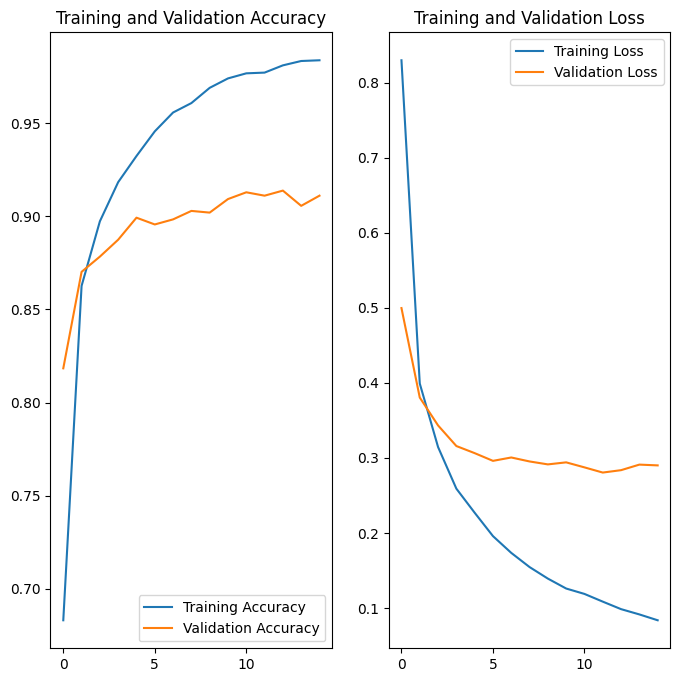

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

What is a bit curious here is that validation performance is better than training performance, right from the start to the end of execution.

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Flower images.

# Check Predictions

In the cell below get the label names from the dataset info and convert them into a NumPy array. Print the array to make sure you have the correct label names.

In [13]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


### Create an Image Batch and Make Predictions

In the cell below, use the `next()` function to create an `image_batch` and its corresponding `label_batch`. Convert both the `image_batch` and `label_batch` to numpy arrays using the `.numpy()` method. Then use the `.predict()` method to run the image batch through your model and make predictions. Then use the `np.argmax()` function to get the indices of the best prediction for each image. Finally convert the indices of the best predictions to class names.

In [14]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

1/1 [==============================] - 1s 721ms/step
['tulips' 'sunflowers' 'roses' 'daisy' 'dandelion' 'dandelion' 'roses'
 'dandelion' 'dandelion' 'roses' 'dandelion' 'tulips' 'dandelion'
 'dandelion' 'tulips' 'roses' 'dandelion' 'tulips' 'tulips' 'roses'
 'roses' 'tulips' 'tulips' 'tulips' 'sunflowers' 'daisy' 'sunflowers'
 'daisy' 'daisy' 'tulips' 'tulips' 'daisy']


### Print True Labels and Predicted Indices

In the cell below, print the true labels and the indices of predicted labels.

In [15]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [2 3 4 3 0 0 4 0 3 4 0 2 0 0 2 4 0 2 2 4 4 2 2 2 3 1 3 1 1 2 2 1]
Predicted labels:  [2 3 4 1 0 0 4 0 0 4 0 2 0 0 2 4 0 2 2 4 4 2 2 2 3 1 3 1 1 2 2 1]


# Plot Model Predictions

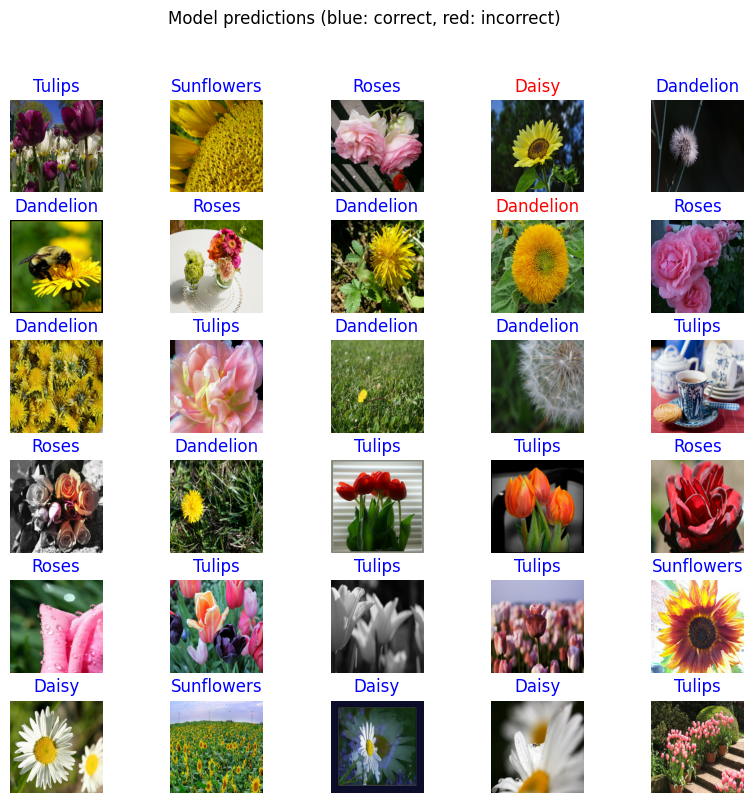

In [21]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

# Perform Transfer Learning with the Inception Model

Go to the [TensorFlow Hub documentation](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) and click on `tf2-preview/inception_v3/feature_vector`. This feature vector corresponds to the Inception v3 model. In the cells below, use transfer learning to create a CNN that uses Inception v3 as the pretrained model to classify the images from the Flowers dataset. Note that Inception, takes as input, images that are 299 x 299 pixels. Compare the accuracy you get with Inception v3 to the accuracy you got with MobileNet v2.

In [17]:
IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    with_info=True,
    as_supervised=True,
    split=['train[:70%]', 'train[70%:]'],
)
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21813029 (83.21 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [18]:
model_inception.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 15

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/15
81/81 [==============================] - 33s 286ms/step - loss: 0.7289 - accuracy: 0.7454 - val_loss: 0.4331 - val_accuracy: 0.8683
Epoch 2/15
81/81 [==============================] - 14s 169ms/step - loss: 0.3788 - accuracy: 0.8836 - val_loss: 0.3860 - val_accuracy: 0.8719
Epoch 3/15
81/81 [==============================] - 13s 165ms/step - loss: 0.3069 - accuracy: 0.9035 - val_loss: 0.3136 - val_accuracy: 0.8919
Epoch 4/15
81/81 [==============================] - 13s 165ms/step - loss: 0.2559 - accuracy: 0.9241 - val_loss: 0.2917 - val_accuracy: 0.9028
Epoch 5/15
81/81 [==============================] - 15s 182ms/step - loss: 0.2281 - accuracy: 0.9346 - val_loss: 0.2796 - val_accuracy: 0.9037
Epoch 6/15
81/81 [==============================] - 15s 179ms/step - loss: 0.1967 - accuracy: 0.9459 - val_loss: 0.2705 - val_accuracy: 0.9074
Epoch 7/15
81/81 [==============================] - 15s 181ms/step - loss: 0.1771 - accuracy: 0.9482 - val_loss: 0.2767 - val_accuracy: 0.9092

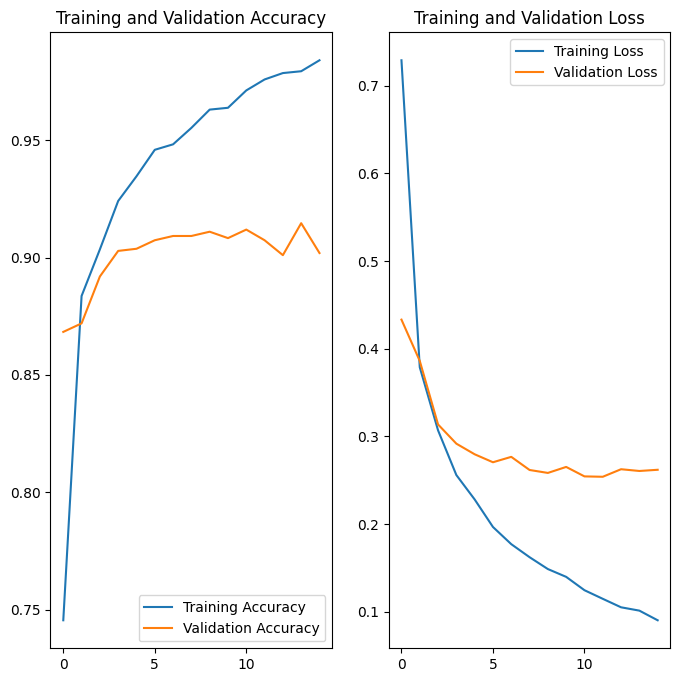

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()